# Epoch Model Insomnia Score
Training epoch-level models to predict how long insomnia will last etc.

In [273]:
import numpy as np
import pandas as pd
import run_yasa
import logging
import mne
import yasa
import os
import argparse
import os

import mne
import numpy as np
import pandas as pd
from brainflow.board_shim import BoardShim, BoardIds
from brainflow.data_filter import DataFilter

from memory import garbage_collect

log = lambda msg: logging.info(msg)


# Load data

In [274]:
input_dir = "C:\\dev\\play\\brainwave-data"


In [345]:
import stitch_pipeline_results
from importlib import reload
reload(stitch_pipeline_results)

df_orig = stitch_pipeline_results.stitch_all_days_optimised(input_dir)
df = df_orig.copy()

  0%|          | 0/118 [00:00<?, ?it/s]

C:\dev\play\brainwave-processor\stitch_pipeline_results.py:148: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  
C:\dev\play\brainwave-processor\stitch_pipeline_results.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 190.5  190.   189.5 ... -425.  -425.5 -426. ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[group.index, 'SSMinsUntilLongWake'] = (df.loc[first_long_wake_idx, 'Timestamp'] - df.loc[group.index, 'Timestamp']).dt.total_seconds() / 60


In [ ]:
days_to_drop = [
    # It's just a bit messy.  Was insomniac but doesn't register a long wake since I'm maybe drifting.
    # Don't want to confuse model.
    '2024-11-05'
]

df = df[~df['dayAndNightOf'].isin(days_to_drop)]

⚠️ **Note:** To evaluate new results against the current best model, skip to `# Looking at model results across all days`
Remember to do the morning review first!

In [277]:
import sys
from importlib import reload
import models.util.features
reload(models.util.features)
import epoch_model_insomnia
reload(epoch_model_insomnia)

models_and_data = epoch_model_insomnia.create_and_add_all(df, False )

from models.final_wake.final_wake_model import ModelAndData
from sklearn.model_selection import train_test_split

def split(modelAndData: ModelAndData):
    X_train_to_sleep, X_val_to_sleep, y_train_to_sleep, y_val_to_sleep = train_test_split(modelAndData.X, modelAndData.y, test_size=0.1, random_state=42)
    modelAndData.X_train = X_train_to_sleep
    modelAndData.y_train = y_train_to_sleep
    modelAndData.X_val = X_val_to_sleep
    modelAndData.y_val = y_val_to_sleep

for md in models_and_data:
    split(md)
    print(f"Training set size {md.name}: {len(md.X_train)}, validation set size: {len(md.X_val)}")

NaN indices: [] (0 total of 92196)
Infinity indices: []
Too large indices: []
CleanTargetCol (92196, 210) to (92196, 210)
Condition (92196, 210) to (92196, 210)
FeaturesHandler (92196, 210) to (92196, 210) Had 210 features, after filtering have features ['HR', 'HrvRMSSDSomewhatRecent', 'Main_eeg_abspow_p2min_norm_s', 'Main_eeg_abspow_s', 'Main_eeg_alpha_p2min_norm_s', 'Main_eeg_alpha_s', 'Main_eeg_alphaaa_p2min_norm_s', 'Main_eeg_alphaaa_s', 'Main_eeg_alphaab_p2min_norm_s', 'Main_eeg_alphaab_s', 'Main_eeg_alphaabs_p2min_norm_s', 'Main_eeg_alphaabs_s', 'Main_eeg_alphaabsaa_p2min_norm_s', 'Main_eeg_alphaabsaa_s', 'Main_eeg_alphaabsab_p2min_norm_s', 'Main_eeg_alphaabsab_s', 'Main_eeg_at_p2min_norm_s', 'Main_eeg_at_s', 'Main_eeg_auc_p2min_norm_s', 'Main_eeg_auc_s', 'Main_eeg_beta_p2min_norm_s', 'Main_eeg_beta_s', 'Main_eeg_betaabs_p2min_norm_s', 'Main_eeg_betaabs_s', 'Main_eeg_db_p2min_norm_s', 'Main_eeg_db_s', 'Main_eeg_ds_p2min_norm_s', 'Main_eeg_ds_s', 'Main_eeg_dt_p2min_norm_s', 'Main_

# Train XGBoost model

In [278]:
from models.util.rfe_training import train_rfe
from models.util.evaluation import evaluate_regression_model_quick
from dataclasses import dataclass
import xgboost as xgb
from sklearn.feature_selection import RFE
import models.util.importances as importances
from importlib import reload
reload(importances)
import memory


for md in models_and_data:
    def get_model():
        if md.is_classifier:
            model = xgb.XGBClassifier(
                n_estimators=200,
                max_depth=8,
                learning_rate=0.1,
            )
        else:
            model = xgb.XGBRegressor(
                n_estimators=200,
                max_depth=8,
                learning_rate=0.1,
            )
        return (model, {
            "source": "xgb"
        })

    md.models = train_rfe(get_model, md.name, md.X_train, md.y_train, md.X_val, md.y_val, do_rfe=True)
    memory.garbage_collect(print)



import models.util.evaluation as evaluation
from importlib import reload
reload(evaluation)

evaluation.evaluate_regression_models(models_and_data)
evaluation.evaluate_classification_models(models_and_data)


Training RFE model for SSLongWakeThisNightAndIsBeforeNoTime with 108 features... RMSE train: 0.0 RMSE val: 0.037549677868472194
Training RFE model for SSLongWakeThisNightAndIsBeforeNoTime with 54 features... RMSE train: 0.0 RMSE val: 0.03896714228518928
Training RFE model for SSLongWakeThisNightAndIsBeforeNoTime with 27 features... RMSE train: 0.0 RMSE val: 0.04884789797585395
Training RFE model for SSLongWakeThisNightAndIsBeforeNoTime with 13 features... RMSE train: 0.06248794716023891 RMSE val: 0.13049214369516857
Training RFE model for SSLongWakeThisNightAndIsBeforeNoTime with 9 features... RMSE train: 0.0711456575574281 RMSE val: 0.13049214369516857
Training RFE model for SSLongWakeThisNightAndIsBeforeNoTime with 5 features... RMSE train: 0.12684238088017175 RMSE val: 0.16267823530807712
Memory Usage: 924.04 MB GC to 1290.84 MB


,RowsTrain,AccVal,PrecVal,RecVal,F1Val,TPVal,FPVal,TNVal,FNVal,AccTrain,PrecTrain,RecTrain,F1Train,TPTrain,FPTrain,TNTrain,FNTrain,Model,n_features,source
0,82976,0.998590,0.995349,0.974943,0.985040,428,2,8779,11,1.000000,1.000000,1.000000,1.000000,3917,0,79059,0,SSLongWakeThisNightAndIsBeforeNoTime,108,xgb
1,82976,0.998482,0.993039,0.974943,0.983908,428,3,8778,11,1.000000,1.000000,1.000000,1.000000,3917,0,79059,0,SSLongWakeThisNightAndIsBeforeNoTime,54,xgb
2,82976,0.997614,0.988290,0.961276,0.974596,422,5,8776,17,1.000000,1.000000,1.000000,1.000000,3917,0,79059,0,SSLongWakeThisNightAndIsBeforeNoTime,27,xgb
3,82976,0.982972,0.946203,0.681093,0.792053,299,17,8764,140,0.996095,0.995040,0.921879,0.957063,3611,18,79041,306,SSLongWakeThisNightAndIsBeforeNoTime,13,xgb
4,82976,0.982972,0.949045,0.678815,0.791501,298,16,8765,141,0.994938,0.993230,0.898902,0.943715,3521,24,79035,396,SSLongWakeThisNightAndIsBeforeNoTime,9,xgb
5,82976,0.973536,0.904564,0.496583,0.641176,218,23,8758,221,0.983911,0.969796,0.680368,0.799700,2665,83,78976,1252,SSLongWakeThisNightAndIsBeforeNoTime,5,xgb


In [279]:
from models.util.importances import xgboost_importances

xgboost_importances(models_and_data[0].models[0].model)

,Feature,Importance
103,Temp,768.0
0,HR,393.0
54,Main_eeg_petrosian_p2min_norm_s,270.0
22,Main_eeg_betaabs_p2min_norm_s,247.0
66,Main_eeg_sigmaabs_p2min_norm_s,236.0
...,...,...
92,Movement,3.0
41,Main_eeg_fdeltaabsab_s,3.0
98,SSN1,2.0
71,Main_eeg_sigmaabsab_s,2.0


In [ ]:
import models.util.evaluation as evaluation
from importlib import reload
reload(evaluation)

evaluation.evaluate_classification_models(models_and_data)


In [299]:
bm_idx = 0
bs_idx = 2
bm = models_and_data[bm_idx].models[bs_idx]
bst = bm.model
bm

ModelAndSettings(model=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...), name='SSLongWakeThisNightAndIsBeforeNoTime', X_train=        Temp    HR  Main_eeg_petrosian_p2min_norm_s  \
18250  36.40  69.0                         0.296269   
43070  36.37  60.0                         0.720899   
22566

In [306]:
from sklearn.model_selection import cross_val_score

# Assuming bm is an instance of xgb.XGBRegressor or xgb.XGBClassifier
X = bm.X_train
y = bm.y_train

# Perform 5-fold cross-validation
cv_scores = cross_val_score(bm.model, X, y, cv=5, scoring='neg_mean_squared_error')

# Print the cross-validation scores
print("Cross-validation scores (MSE):", -cv_scores)
print("Mean MSE:", -cv_scores.mean())
print("Standard deviation of MSE:", cv_scores.std())

Cross-validation scores (MSE): [0.00301277 0.00313347 0.00253088 0.00373607 0.00355529]
Mean MSE: 0.0031936967427036765
Standard deviation of MSE: 0.00042440394782762147


In [323]:

from models.util.model_features import get_xgboost_feature_names


def predict(model, df_in, output_col_prefix):
    df_out = df_in.copy()

    models_and_data_for_df = epoch_model_insomnia.create_and_add_all(df_in, True)
    feature_names = get_xgboost_feature_names(model)
    prediction_s = models_and_data_for_df[bm_idx].prepared_df[feature_names]
    preds = model.predict(prediction_s)
    preds_proba = model.predict_proba(prediction_s)

    # preds_padded = pd.Series(preds).reindex(df_for_day.index, fill_value=np.nan)
    # preds_proba_padded = pd.DataFrame(preds_proba).reindex(df_for_day.index, fill_value=np.nan)

    # Add the original and padded predictions to the dataframe
    # df_out[output_col_prefix + 'Prediction'] = preds_padded
    # df_out[output_col_prefix + 'Probability'] = preds_proba_padded.iloc[:, 1]
    df_out[output_col_prefix + 'Prediction'] = preds
    df_out[output_col_prefix + 'Probability'] = preds_proba[:, 1]

    return df_out


def draw_for_day(interesting_day):

    df_for_day = df[df['dayAndNightOf'] == interesting_day].reset_index()
    df_for_day = predict(bm.model, df_for_day, bm.name)

draw_for_day("2024-12-28")

Condition (1315, 211) to (1315, 211)
FeaturesHandler (1315, 211) to (1315, 211) Had 211 features, after filtering have features ['HR', 'HrvRMSSDSomewhatRecent', 'Main_eeg_abspow_p2min_norm_s', 'Main_eeg_abspow_s', 'Main_eeg_alpha_p2min_norm_s', 'Main_eeg_alpha_s', 'Main_eeg_alphaaa_p2min_norm_s', 'Main_eeg_alphaaa_s', 'Main_eeg_alphaab_p2min_norm_s', 'Main_eeg_alphaab_s', 'Main_eeg_alphaabs_p2min_norm_s', 'Main_eeg_alphaabs_s', 'Main_eeg_alphaabsaa_p2min_norm_s', 'Main_eeg_alphaabsaa_s', 'Main_eeg_alphaabsab_p2min_norm_s', 'Main_eeg_alphaabsab_s', 'Main_eeg_at_p2min_norm_s', 'Main_eeg_at_s', 'Main_eeg_auc_p2min_norm_s', 'Main_eeg_auc_s', 'Main_eeg_beta_p2min_norm_s', 'Main_eeg_beta_s', 'Main_eeg_betaabs_p2min_norm_s', 'Main_eeg_betaabs_s', 'Main_eeg_db_p2min_norm_s', 'Main_eeg_db_s', 'Main_eeg_ds_p2min_norm_s', 'Main_eeg_ds_s', 'Main_eeg_dt_p2min_norm_s', 'Main_eeg_dt_s', 'Main_eeg_fdelta_p2min_norm_s', 'Main_eeg_fdelta_s', 'Main_eeg_fdeltaaa_p2min_norm_s', 'Main_eeg_fdeltaaa_s', 'Main

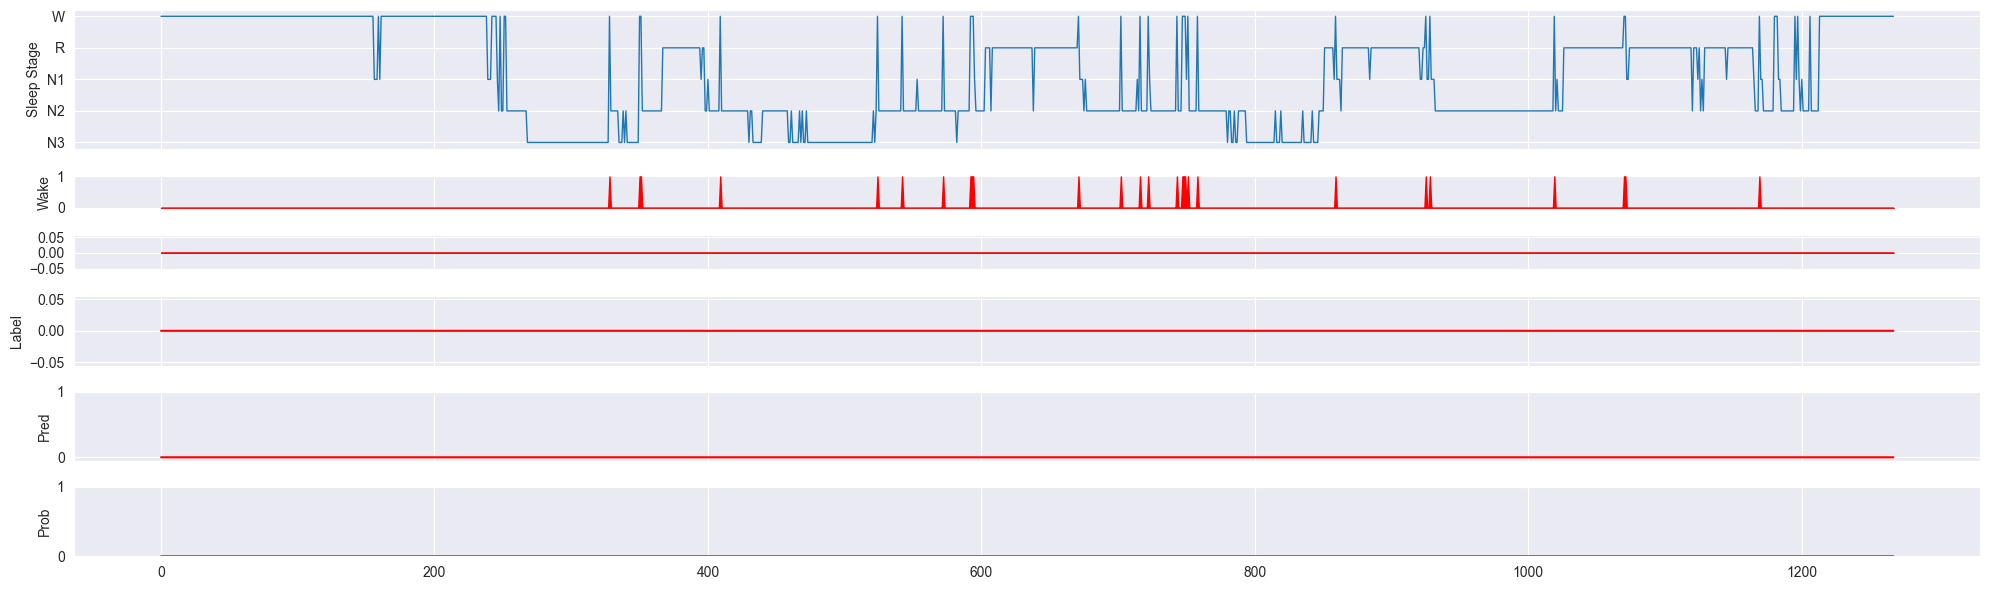

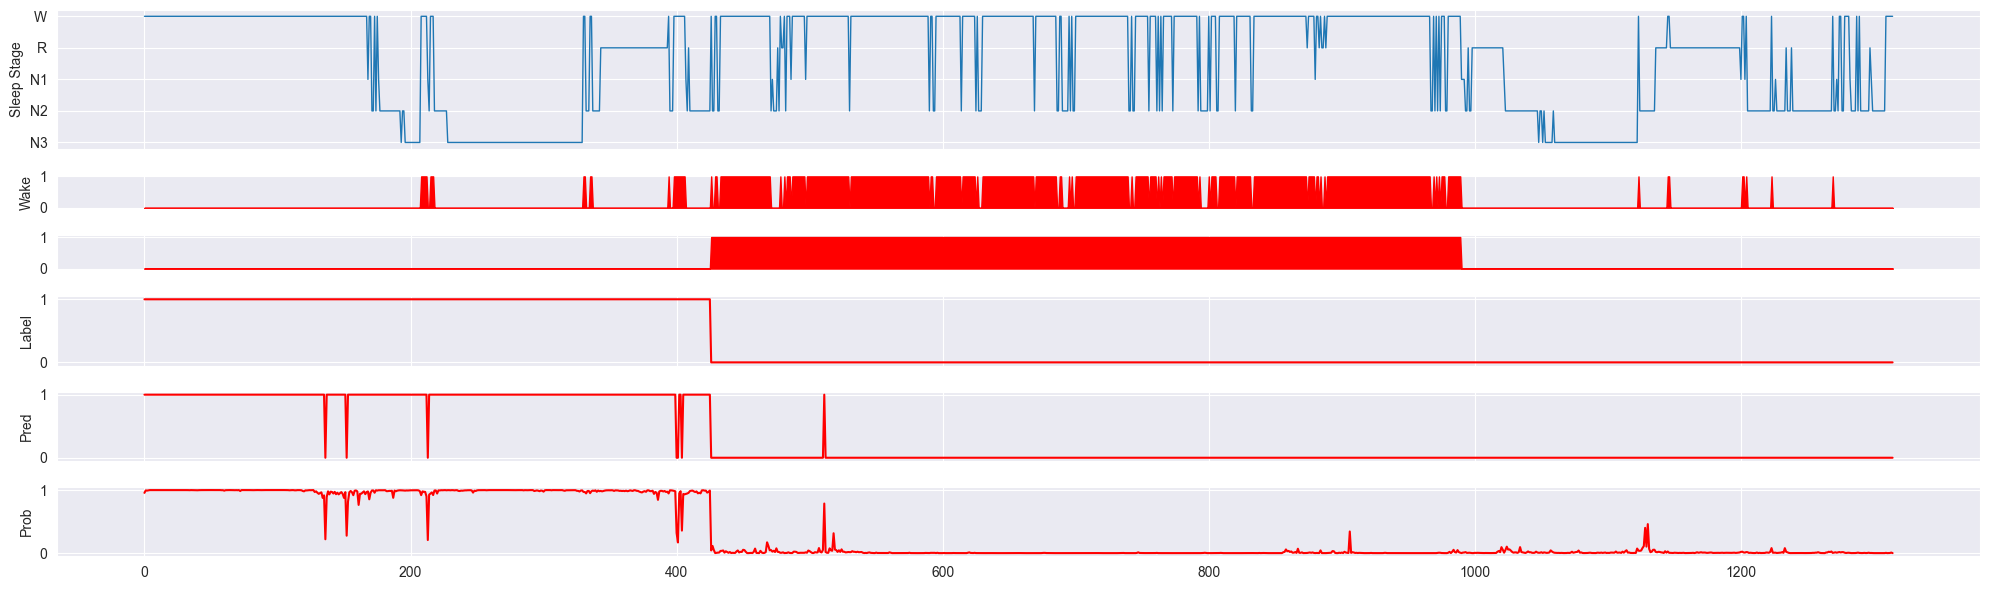

In [364]:
from importlib import reload
import models.util.features
reload(models.util.features)
import epoch_model_insomnia
reload(epoch_model_insomnia)
import matplotlib.pyplot as plt
import io
import contextlib

def draw_for_day(interesting_day, model):

    df_for_day = df[df['dayAndNightOf'] == interesting_day].reset_index()
    f = io.StringIO()
    model_name = "Temp"
    with contextlib.redirect_stdout(f):
        df_for_day = predict(model, df_for_day, model_name)

    # Plot hypnogram

    # Map stages to numeric values for plotting
    stage_map = {'W': 4, 'R': 3, 'N1': 2, 'N2': 1, 'N3': 0}
    stage_values = df_for_day['Stage'].map(stage_map)

    fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(20, 6), sharex=True, gridspec_kw={'height_ratios': [2, 0.5, 0.5, 1, 1, 1]})

    # Plot stages
    ax1.plot(stage_values, linewidth=1)
    ax1.set_yticks(list(stage_map.values()))
    ax1.set_yticklabels(list(stage_map.keys()))
    ax1.set_ylabel('Sleep Stage')
    ax1.grid(True)

    # Plot long wakes
    ax2.fill_between(df_for_day.index, 0, df_for_day['SSWakeDuringSleep'].astype(int), color='red')
    ax2.set_ylabel('Wake')

    ax3.fill_between(df_for_day.index, 0, df_for_day['SSDuringLongWake'].astype(int), color='red')
    ax4.set_ylabel('LongWake')

    ax4.plot(df_for_day['SSLongWakeThisNightAndIsBefore'], color='red')
    ax4.set_ylabel('Label')

    ax5.plot(df_for_day[model_name + 'Prediction'], color='red')
    ax5.set_yticks([0,1])
    ax5.set_ylabel('Pred')

    ax6.plot(df_for_day[model_name + 'Probability'], color='red')
    ax6.set_yticks([0,1])
    ax6.set_ylabel('Prob')

    plt.tight_layout()
    plt.show()

draw_for_day("2024-12-27", bm.model)
draw_for_day("2024-12-28", bm.model)

# Most useful features

In [ ]:
from xgboost import plot_tree
import matplotlib.pyplot as plt

# Plot the 0th tree
#xgb.to_graphviz(bst, num_trees=1)
# plt.show()


In [ ]:
# Install SHAP if you haven't already
# !pip install shap

import shap
import xgboost as xgb

# Create a DMatrix for SHAP
# dmatrix = xgb.DMatrix(bm.X_train)

# Initialize the SHAP explainer
explainer = shap.Explainer(bm.model)

# Calculate SHAP values
shap_values = explainer(bm.X_train)

shap_values.shape

In [ ]:
shap.plots.bar(shap_values, max_display=20)


In [ ]:
shap.plots.beeswarm(shap_values, max_display=20)


In [ ]:
# Calculate the mean absolute SHAP values for each feature
mean_abs_shap_values = np.abs(shap_values.values).mean(axis=0)

# Get the indices of the top 16 features
top_features_indices = np.argsort(mean_abs_shap_values)[-16:][::-1]

# Get the names of the top 16 features
top_features = [shap_values.feature_names[i] for i in top_features_indices]

In [ ]:
import matplotlib.pyplot as plt
import shap

# Create a 4x4 grid
fig, axes = plt.subplots(4, 4, figsize=(20, 20))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each feature
for i, feature in enumerate(top_features):
    shap.plots.scatter(shap_values[:, feature], ax=axes[i], show=False, xmin='percentile(1)', xmax='percentile(99)', alpha=0.5)  # Avoid triggering plt.show()
    axes[i].set_title(feature)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [ ]:
xgb.to_graphviz(bst, num_trees=0)

# Save model

In [326]:
model_filename = f"models/cls_best_xgboost_model.cbm"
print(f"Saving best model to {model_filename}")
bm.model.save_model(model_filename)

for md in models_and_data:
    for ms in md.models:
        model_filename = f"models/{'cls' if md.is_classifier else 'reg'}_{md.name}_rfe{len(ms.X_train.columns)}_xgboost_model.cbm"
        print(f"Saving model to {model_filename}")
        ms.model.save_model(model_filename)

Saving best model to models/cls_best_xgboost_model.cbm
Saving model to models/cls_SSLongWakeThisNightAndIsBeforeNoTime_rfe108_xgboost_model.cbm
Saving model to models/cls_SSLongWakeThisNightAndIsBeforeNoTime_rfe54_xgboost_model.cbm
Saving model to models/cls_SSLongWakeThisNightAndIsBeforeNoTime_rfe27_xgboost_model.cbm
Saving model to models/cls_SSLongWakeThisNightAndIsBeforeNoTime_rfe13_xgboost_model.cbm
Saving model to models/cls_SSLongWakeThisNightAndIsBeforeNoTime_rfe9_xgboost_model.cbm
Saving model to models/cls_SSLongWakeThisNightAndIsBeforeNoTime_rfe5_xgboost_model.cbm


C:\Users\graha\.conda\envs\tf\lib\site-packages\xgboost\core.py:158: UserWarning: [08:55:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


# Looking at model results across all days

In [335]:
from datetime import datetime

best_model_filename = "models/cls_best_xgboost_model.cbm"
loaded_model = xgb.XGBClassifier()
loaded_model.load_model(best_model_filename)

modification_time = os.path.getmtime(best_model_filename)
modification_date = datetime.fromtimestamp(modification_time)
print(f"Modification date of {best_model_filename}: {modification_date}")

Modification date of models/cls_best_xgboost_model.cbm: 2024-12-31 08:55:18.931331


In [348]:
# x = pd.DataFrame()
model_name = "Insomnia"
x = predict(loaded_model, df, model_name)
# x['Prediction'] = all_predicted
x[model_name + 'Label'] = models_and_data[0].y
x[model_name + 'PredictionError'] = x[model_name + 'Prediction'] - x[model_name + 'Label']
x[model_name + 'PredictionErrorAbs'] = x[model_name + 'PredictionError'].abs()
# x.index = models_and_data[0].X.index
# x['Timestamp'] = df['Timestamp']


Condition (93471, 210) to (93471, 210)
FeaturesHandler (93471, 210) to (93471, 210) Had 210 features, after filtering have features ['HR', 'HrvRMSSDSomewhatRecent', 'Main_eeg_abspow_p2min_norm_s', 'Main_eeg_abspow_s', 'Main_eeg_alpha_p2min_norm_s', 'Main_eeg_alpha_s', 'Main_eeg_alphaaa_p2min_norm_s', 'Main_eeg_alphaaa_s', 'Main_eeg_alphaab_p2min_norm_s', 'Main_eeg_alphaab_s', 'Main_eeg_alphaabs_p2min_norm_s', 'Main_eeg_alphaabs_s', 'Main_eeg_alphaabsaa_p2min_norm_s', 'Main_eeg_alphaabsaa_s', 'Main_eeg_alphaabsab_p2min_norm_s', 'Main_eeg_alphaabsab_s', 'Main_eeg_at_p2min_norm_s', 'Main_eeg_at_s', 'Main_eeg_auc_p2min_norm_s', 'Main_eeg_auc_s', 'Main_eeg_beta_p2min_norm_s', 'Main_eeg_beta_s', 'Main_eeg_betaabs_p2min_norm_s', 'Main_eeg_betaabs_s', 'Main_eeg_db_p2min_norm_s', 'Main_eeg_db_s', 'Main_eeg_ds_p2min_norm_s', 'Main_eeg_ds_s', 'Main_eeg_dt_p2min_norm_s', 'Main_eeg_dt_s', 'Main_eeg_fdelta_p2min_norm_s', 'Main_eeg_fdelta_s', 'Main_eeg_fdeltaaa_p2min_norm_s', 'Main_eeg_fdeltaaa_s', '

In [349]:
import models.util.nights as n
actual_insomnia_nights_set = set(n.actual_insomnia_nights)

grouped = x.groupby('dayAndNightOf').agg(
    HasLongWake=('SSLongWakeThisNight', 'any'),
    LabelSum=('SSLongWakeThisNightAndIsBefore', 'sum'),
    PredSum=(model_name + 'Prediction', lambda y: y.sum()),
    ProbSum=(model_name + 'Probability', lambda y: y.sum()),
    PredErrSum=(model_name + 'PredictionError', 'sum'),
).reset_index()
grouped['ActualInsomnia'] = grouped['dayAndNightOf'].apply(lambda x: str(x.date()) in actual_insomnia_nights_set)
grouped

,dayAndNightOf,HasLongWake,LabelSum,PredSum,ProbSum,PredErrSum,ActualInsomnia
0,2024-07-11,False,0,0,0.007978,0,False
1,2024-07-12,False,0,0,0.007606,0,False
2,2024-07-15,False,0,0,0.004576,0,False
3,2024-07-16,False,0,0,0.007384,0,False
4,2024-07-17,False,0,0,0.008584,0,False
...,...,...,...,...,...,...,...
75,2024-12-21,False,0,0,0.018016,0,False
76,2024-12-27,False,0,0,0.018890,0,False
77,2024-12-28,True,426,421,424.939148,-5,True
78,2024-12-29,False,0,0,0.019569,0,False


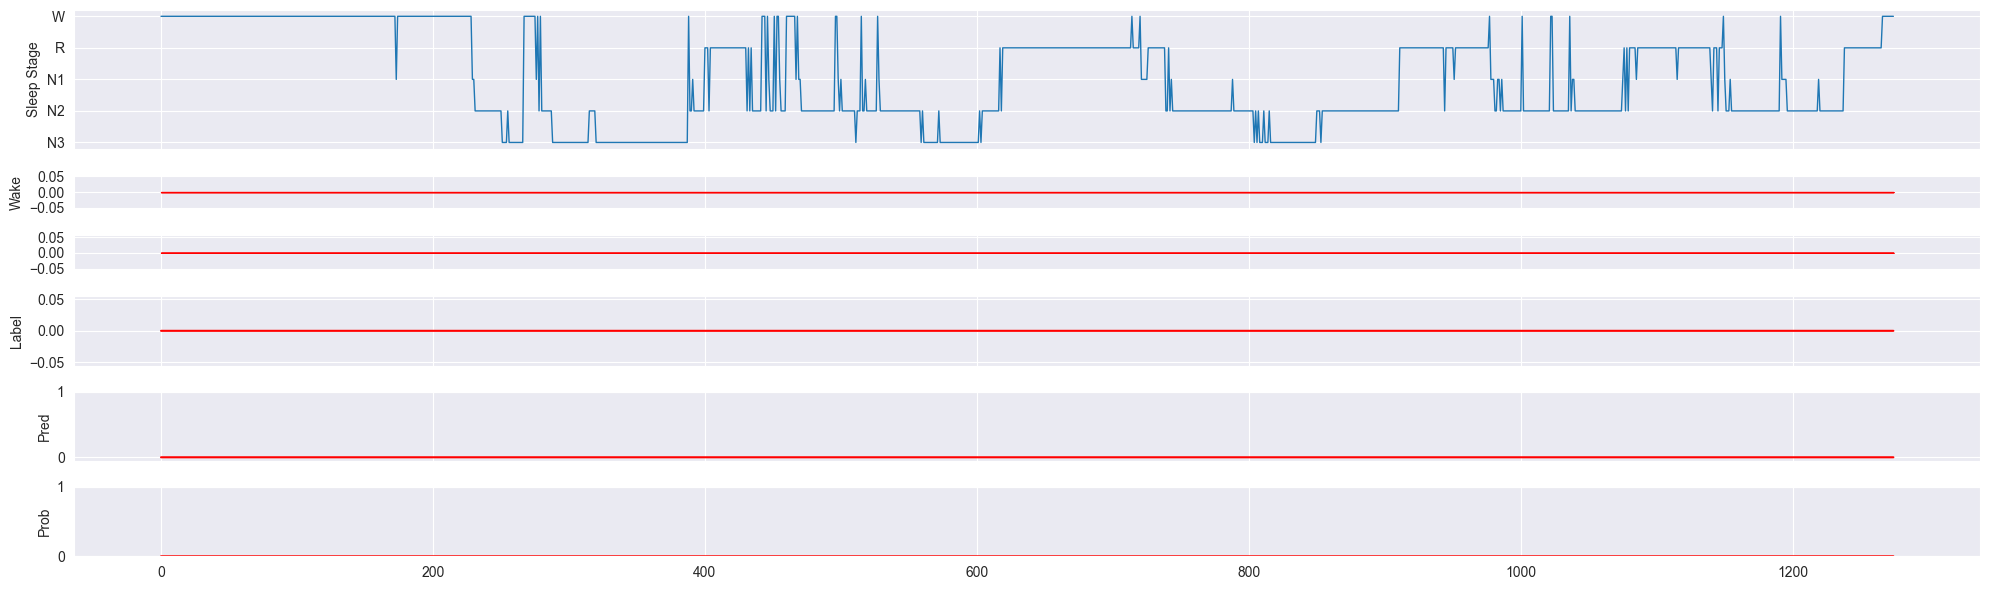

In [365]:
draw_for_day("2024-12-30", loaded_model)

In [350]:
false_negative_days = grouped[(grouped['ActualInsomnia'] == True) & (grouped['PredSum'] < 200)]
false_negative_days

,dayAndNightOf,HasLongWake,LabelSum,PredSum,ProbSum,PredErrSum,ActualInsomnia
48,2024-11-05,False,0,0,0.006678,0,True


In [351]:
false_positive_days = grouped[(grouped['ActualInsomnia'] == False) & (grouped['PredSum'] > 50)]
false_positive_days


,dayAndNightOf,HasLongWake,LabelSum,PredSum,ProbSum,PredErrSum,ActualInsomnia
